### Imports

In [ ]:
# Mount Google drive and unzip "sign_data.zip" file
from google.colab import drive
drive.mount('/content/drive')
!unzip drive/My\ Drive/sign_data.zip

In [ ]:
import math
import statistics
import os
import copy
import time
import torch
import torchvision
import numpy as np
import pandas as pd 
import PIL.ImageOps 
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.stats import skew
from sklearn.cluster import KMeans
from sklearn import metrics

### Data Preprrocessing

In [ ]:
# Create a dictionary of person_id and corresponding signature list
sig_dict = {}
train_directory = '/content/sign_data/train/'
for folder in os.listdir(train_directory):
  img_set = set()
  for img in os.listdir(train_directory+folder):
    img_set.add(folder+'/'+img)
  sig_dict[folder] = pd.DataFrame(list(img_set))

In [ ]:
# This function creates a 75:25 split for genuine and forged images of a person
# and return data frames of the images.
def get_sig_dfs(person):
  df_genuine = pd.DataFrame(sig_dict[person])
  genuine_samples = df_genuine.sample(frac=0.25, random_state=0)
  df_genuine.drop(genuine_samples.index, inplace=True)
  df_genuine.reset_index(drop=True, inplace=True)

  df_forged = pd.DataFrame(sig_dict[person+'_forg'])
  forged_samples = df_forged.sample(frac=0.25, random_state=0)
  df_forged.drop(forged_samples.index, inplace=True)
  df_forged.reset_index(drop=True, inplace=True)

  df_test = pd.concat([genuine_samples, forged_samples]).reset_index(drop=True)
  return df_genuine, df_forged, df_test

In [ ]:
# Transform image by converting from RGB to Binary array.
def transform_image(f):
    img= Image.open(f)  
    img = img.convert('L')
    img = np.array(img)
    bin_arr = np.where(img < 220, 1, 0)
    return bin_arr

### Training and Evauation

In [ ]:
# Extract coordinates corresponding to the signature part in the image.
def get_sig_cord(img_arr):
  cord_list = []
  for i in range (0, len(img_arr)):
    for j in range (0, len(img_arr[i])):
      if img_arr[i][j] == 1:
        cord_list.append([i, j])
  return cord_list

In [ ]:
# Compute euclidian distance between (x1, y1) and (x2, y2)
def euclidian_distance(x1_cor, y1_cor, x2_cor, y2_cor):
  squared = math.pow(abs(x1_cor - x2_cor), 2) + math.pow(abs(y1_cor - y2_cor), 2)
  root = math.sqrt(squared)
  return root

In [ ]:
# Perform k-means clustering on the pixel list with desired cluster size and returns
# a DataFrame consisting of the corrdinates and their corresponding cluster assignment.
def generate_df(px_list, num_clusters):
  df_list = []
  for i in range (0, len(px_list)):
    cor_list = get_sig_cord(px_list[i])
    model = KMeans(n_clusters=num_clusters, random_state=0).fit(cor_list)
    df = pd.DataFrame({
    'cluster': model.labels_,
    'coordinates':cor_list
    })
    df_list.append(df)
  return df_list

In [ ]:
# Computes centroids of the clusters formed and returns their coordinates.
def get_centroids_coordinates(df, num_cluster):
  centroid_dict = {}

  for c in range (0, num_cluster):
    x_sum = 0
    y_sum = 0
    t_df = df[df['cluster'] == c]['coordinates']
    for row in t_df.iteritems():
      x_sum += row[1][0]
      y_sum += row[1][1]
    x_sum /= len(t_df)
    y_sum /= len(t_df)

    centroid_dict[c] = [x_sum, y_sum]

  for c in centroid_dict.keys():
    euc_sum = 0
    centroid = centroid_dict[c]
    t_df = df[df['cluster'] == c]['coordinates']
    euc_dist = 0
    for row in t_df.iteritems():
      euc_dist += euclidian_distance(centroid[0], centroid[1], row[1][0], row[1][1])
    euc_dist /= len(t_df)
  return centroid_dict

In [ ]:
# Extracts centroids coordinate into a list and sort them by x values.
def convert_list_util(centroid_dict_list):
  main_list = []
  for l1 in centroid_dict_list:
    sub_list = []
    for l2 in list(l1.values()):
      sub_list.append(l2)
    main_list.append(Sort(sub_list))
  return main_list

In [ ]:
# Sort utility function.
def Sort(sub_li):
    sub_li.sort(key = lambda x: x[0]) 
    return sub_li

In [ ]:
def get_sorted_centroids(person_id, num_clusters): 
  # Fetch dataframes for Genuine, Forged and Test images of a particular person.
  df_o, df_f, df_test = get_sig_dfs(person_id)
  px_list_o = []
  px_list_f = []
  px_list_test = []

  # Apply transformation on the images.
  for row in df_o.iterrows():
    px_list_o.append(transform_image(train_directory+row[1][0]))

  for row in df_f.iterrows():
    px_list_f.append(transform_image(train_directory+row[1][0]))

  for row in df_test.iterrows():
    px_list_test.append(transform_image(train_directory+row[1][0]))

  # Performing k-means clustering withing images from Genuine, Forged and Test Dataframes
  df_list_o = generate_df(px_list_o, num_clusters)
  df_list_f = generate_df(px_list_f, num_clusters)
  df_list_test = generate_df(px_list_test, num_clusters)

  centroid_dict_list_o = []
  centroid_dict_list_f = []
  centroid_dict_list_test = []

  # Get centroids of the clusters formed for images in Genuine, Forged and Test dataframes.
  for df in df_list_o:
    centroid_dict_list_o.append(get_centroids_coordinates(df, num_clusters))
  for df in df_list_f:
    centroid_dict_list_f.append(get_centroids_coordinates(df, num_clusters))
  for df in df_list_test:
    centroid_dict_list_test.append(get_centroids_coordinates(df, num_clusters))
  centroids_list_genuine = convert_list_util(centroid_dict_list_o)
  centroids_list_forged = convert_list_util(centroid_dict_list_f)
  centroid_list_test = convert_list_util(centroid_dict_list_test)

  return centroids_list_genuine, centroids_list_forged, centroid_list_test, df_test

In [ ]:
# Computes average coordinate for cluster k in all genuine images.
def get_average_centroid_coordinates(centroid_sorted_list_o):
  average_coordinates = dict()
  for centroid in range(len(centroid_sorted_list_o[0])):
    average_coordinates[centroid] = [0, 0] 
    for img in range(len(centroid_sorted_list_o)):
      average_coordinates[centroid][0] += centroid_sorted_list_o[img][centroid][0]
      average_coordinates[centroid][1] += centroid_sorted_list_o[img][centroid][1]
    average_coordinates[centroid][0] /= len(centroid_sorted_list_o)
    average_coordinates[centroid][1] /= len(centroid_sorted_list_o)

  return average_coordinates 

In [ ]:
# Computes total average squared distance of centroid of all images from average centroid coordinates.
def total_distance_from_centroids(average_coordinates, centroid_sorted_list):
  total_cluster_distance = [0 for i in range(len(centroid_sorted_list))]
  for img in range(len(centroid_sorted_list)):
    for centroid in range(len(centroid_sorted_list[0])):
      avg_x = centroid_sorted_list[img][centroid][0]
      x = average_coordinates[centroid][0]
      avg_y = centroid_sorted_list[img][centroid][1]
      y = average_coordinates[centroid][1]
      value = (euclidian_distance(avg_x,avg_y, x, y))
      total_cluster_distance[img] += value**2
    total_cluster_distance[img] = total_cluster_distance[img]/len(centroid_sorted_list[0])
  total_cluster_distance = math.sqrt(sum(total_cluster_distance)/len(total_cluster_distance))
  return total_cluster_distance

In [ ]:
# Computes total average squared distance of centroid of a images from average centroid coordinates.
def total_image_distance_from_centroids(average_coordinates, centroid_sorted_list):
  total_cluster_distance = 0
  for centroid in range(len(centroid_sorted_list)):
      avg_x = centroid_sorted_list[centroid][0]
      x = average_coordinates[centroid][0]
      avg_y = centroid_sorted_list[centroid][1]
      y = average_coordinates[centroid][1]
      value = euclidian_distance(avg_x,avg_y, x, y)
      total_cluster_distance += value**2
  total_cluster_distance = math.sqrt(total_cluster_distance/len(centroid_sorted_list))
  return total_cluster_distance

In [ ]:
# Predict the label by comparing mean squared error of test with that of genuine and forged.
def predict_label(centroid_list, average_coordinates, mse_genuine, mse_forged):
  mse_test = total_image_distance_from_centroids(average_coordinates, centroid_list)
  if mse_test < mse_genuine + 0.15 * (mse_forged - mse_genuine):
    return 0
  else:
    return 1

In [ ]:
def predict_forgery(num_cluster, person_ids):
  results = np.array([0, 0, 0, 0])
  for person_id in person_ids:
    prediction_labels = []
    actual_labels = []
    centroids_list_genuine, centroids_list_forged, centroid_list_test, df_test = get_sorted_centroids(person_id, num_cluster)
    average_coordinates  = get_average_centroid_coordinates(centroids_list_genuine)
    mse_genuine = total_distance_from_centroids(average_coordinates, centroids_list_genuine)
    mse_forged = total_distance_from_centroids(average_coordinates, centroids_list_forged)
    for centroid_list in centroid_list_test:
      label = predict_label(centroid_list, average_coordinates, mse_genuine, mse_forged)
      prediction_labels.append(label)
    for row in df_test.iterrows():
      if '_forg' in row[1][0]:
        actual_labels.append(1)
      else:
        actual_labels.append(0)
    
    true_neg, false_pos, false_neg, true_pos = metrics.confusion_matrix(prediction_labels, actual_labels).ravel()
    results = np.add(results, [true_neg, false_pos, false_neg, true_pos])

  total_true_neg, total_false_pos, total_false_neg, total_true_pos = results
  accuracy = (total_true_neg + total_true_pos) / results.sum()
  return accuracy, total_true_neg, total_false_pos, total_false_neg, total_true_pos

In [ ]:
person_dirs = os.listdir(train_directory)
person_ids = list(filter(lambda dirname: '_forg' not in dirname, person_dirs))

In [ ]:
def plot_cluster_accuracy_relation(person_ids):
  accuracy_by_num_clusters = {}
  results = np.array([0, 0, 0, 0])
  for num_clusters in range(2, 15):
    accuracy, true_neg, false_pos, false_neg, true_pos = predict_forgery(num_clusters, person_ids)
    results = np.add(results, [true_neg, false_pos, false_neg, true_pos])
    accuracy_by_num_clusters[num_clusters] = accuracy

  y_values = list(accuracy_by_num_clusters.values())
  plt.plot(list(accuracy_by_num_clusters.keys()), y_values)
  best_num_clusters = max(accuracy_by_num_clusters.items(), key=lambda x: x[1])[0]
  plt.axvline(best_num_clusters, color='#ff0000', linestyle='dashed', linewidth=2)
  min_y = min(y_values)
  max_y = max(y_values)
  text_y = 0.25 * (max_y - min_y) + min_y
  plt.text(best_num_clusters + 0.5, text_y, f'Optimum no. of clusters={best_num_clusters}', rotation=90)
  plt.xticks(range(2, 15))
  plt.title('No. of clusters v/s accuracy')
  plt.xlabel('No. of clusters')
  plt.ylabel('Accuracy')
  plt.show()
  return results

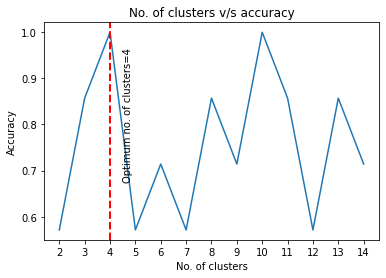

Time taken =  171.42705750465393
True negative: 22
False positive: 5
False negative: 17
True positive: 47


In [ ]:
start_time = time.time()
true_neg, false_pos, false_neg, true_pos = plot_cluster_accuracy_relation(person_ids[:1])
end_time = time.time()
print("Time taken = ", end_time - start_time)
print('True negative:', true_neg)
print('False positive:', false_pos)
print('False negative:', false_neg)
print('True positive:', true_pos)